# Cross-validation riddle

Here's a small example of cross-validation done wrongly. Can you spot the problem?

In [1]:
# Some imports...
import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score

**Plan:**

- Let's create a binary classification dataset where targets are completely independent from the features
  - *(i.e. no model could ever predict them well)*
- We'll do some simple feature selection
- And cross-validate a model on this data

**Q:** what accuracy do we expect (classes are even)?

We'll start from writing a class to select the best features:

In [2]:
class FeatureSelector:
  def __init__(self, num_features):
    self.n = num_features # number of best features to select

  def fit(self, X, y):
    # Select features that describe the targets best, i.e. have
    # highest correlation with them:
    covariance = ((X - X.mean(axis=0)) * (y[:,np.newaxis] - y.mean())).mean(axis=0)
    self.best_feature_ids = np.argsort(np.abs(covariance))[-self.n:]

  def transform(self, X):
    return X[:,self.best_feature_ids]

  def fit_transform(self, X, y):
    self.fit(X, y)
    return self.transform(X)

In [3]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

# Feature selection:
X_best = FeatureSelector(num_features_best).fit_transform(X, y)

# Simple classification model
model = LinearSVC()

# Estimatin accuracy using cross-validation:
cv_score = cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()
print(f"CV score is {cv_score}")

CV score is 0.9600000000000002


What's going on?! Why accuracy is so high?

Maybe it just happened by chance? Let's repeat this experiment many times and histogram the results:

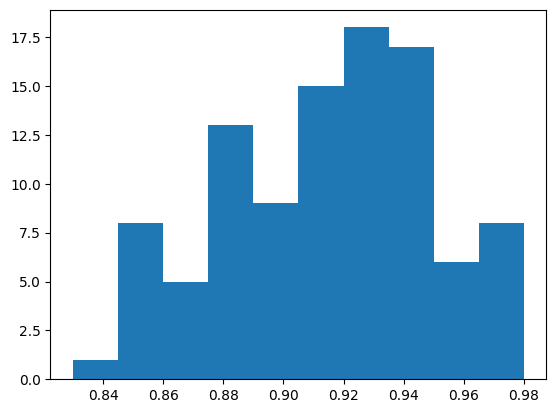

In [4]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Feature selection:
  X_best = FeatureSelector(num_features_best).fit_transform(X, y)

  # Simple classification model
  model = LinearSVC()

  # Estimatin accuracy using cross-validation:
  return cross_val_score(model, X_best, y, scoring='accuracy', cv=10, n_jobs=-1).mean()

results = [experiment() for _ in range(100)]
plt.hist(results, bins=10);

## Task 1 (3 points)

Explain why the estimated model accuracy is not 50% on a dataset where targets were generated **independently from the features (!!!)**.

Find and fix the problem (don't change the dataset generation or its parameters - `num_features_total`, `num_features_best`, `N`).

*Hint: the problem is in the overall logic, and not a bug in the code.*

**ANSWER**  
The problem is that we apply feature selection before separating data into train and test. The feature selector finds features that happened to correlate with the whole target dataset, including the y_test samples. This way the information about test dataset is leaked, which results in higher accuracy.

When we split the data beforehand, the selector looks only for correlation between X_train and y_train. Howewer, as there is no real dependency between X and y, the chosen features will prove useless on the test data.

In [5]:
def crossval(X, y, num_features_best):
  acc_list = []
  kfold = KFold(n_splits=10)
  for i_train, i_test in kfold.split(X):
    X_train = X[i_train]
    X_test = X[i_test]
    y_train = y[i_train]
    y_test = y[i_test]

    f_select = FeatureSelector(num_features_best)
    X_train_best = f_select.fit_transform(X_train, y_train)
    X_test_best = f_select.transform(X_test)

    model = LinearSVC()
    model.fit(X_train_best, y_train)
    y_pred = model.predict(X_test_best)
    acc_i = accuracy_score(y_test, y_pred)
    acc_list.append(acc_i)

  accuracy = sum(acc_list)/len(acc_list)
  return accuracy

In [6]:
num_features_total = 1000
num_features_best = 100

N = 100

# Dataset generation
X = np.random.normal(size=(N, num_features_total))
y = np.random.randint(2, size=N)

cv_score = crossval(X, y, num_features_best)
print(f"CV score is {cv_score}")

CV score is 0.6199999999999999


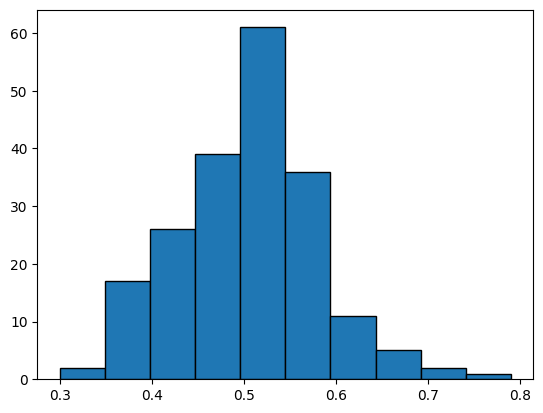

In [7]:
num_features_total = 1000
num_features_best = 100

N = 100
def experiment():
  # Dataset generation
  X = np.random.normal(size=(N, num_features_total))
  y = np.random.randint(2, size=N)

  # Estimatin accuracy using cross-validation:
  return crossval(X, y, num_features_best)

results = [experiment() for _ in range(200)]
plt.hist(results, bins=10, edgecolor='k');

## Task 2 (3 points)

Let's come back to Task 3 of Data Handling HW.
Build a model with KNeighborsClassifier to get a higher accuracy on 5-fold Cross Validation than you achieve using your previosly fitted model (you can just copy the params from the previous notebook).

Use `sklearn.model_selection.GridSearchCV` to find best parameters.  You may check the parameters'  description as follows:
``` python
help(KNeighborsClassifier)
```

In [8]:
!wget https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/01-intro/train.csv

--2024-10-23 17:38:34--  https://raw.githubusercontent.com/HSE-LAMBDA/MLDM-2022/main/01-intro/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60302 (59K) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]  58.89K  --.-KB/s    in 0.01s   

2024-10-23 17:38:34 (4.02 MB/s) - ‘train.csv’ saved [60302/60302]



In [9]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

data = pd.read_csv("train.csv", index_col='PassengerId')

In [10]:
# copypasted from Data Handling HW
def feature_selection_and_preprocessing(dataset):

  features = dataset.copy()
  features.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

  features['Age'] = features['Age'].fillna(features["Age"].mean())

  for f_name in ['Fare', 'SibSp', 'Parch','Age']:
    range = features[f_name].max() - features[f_name].min()
    features[f_name] = (features[f_name] - features[f_name].min())/range

  features = features.join(pd.get_dummies(features['Sex']))
  features.drop(['Sex'], inplace=True, axis=1)

  features = features.join(pd.get_dummies(features['Embarked']))
  features.drop(['Embarked'], inplace=True, axis=1)

  features = features.join(pd.get_dummies(features['Pclass'], prefix='Pclass'))
  features.drop(['Pclass'], inplace=True, axis=1)

  return features

In [13]:
X = feature_selection_and_preprocessing(data.drop('Survived', axis=1))
y = data['Survived']

model = KNeighborsClassifier()
param_grid = {'n_neighbors': np.arange(1, 15)}
gscv = GridSearchCV(model, param_grid, scoring='accuracy', cv=5, n_jobs=-1)

gscv.fit(X, y)

print(f'Best parameters: {gscv.best_params_}')
print(f'Best accuracy: {gscv.best_score_:0.04f}')

Best parameters: {'n_neighbors': 12}
Best accuracy: 0.8092


In [14]:
old_model = KNeighborsClassifier(n_neighbors=5)
old_score = cross_val_score(old_model, X, y, scoring='accuracy', cv=5, n_jobs=-1).mean()
print('Score of the previous model (measured with the use of crossvalidation)\n'
      f'n_neighbors = 5, accuracy = {old_score:.04f}')

Score of the previous model (measured with the use of crossvalidation)
n_neighbors = 5, accuracy = 0.7946
